In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

Length of data: 900
tensor([[0.0118, 1.8866],
        [0.9256, 1.5646],
        [0.9931, 1.2284],
        ...,
        [4.5300, 3.9402],
        [3.8387, 1.7253],
        [4.1143, 3.6691]], device='cuda:0')


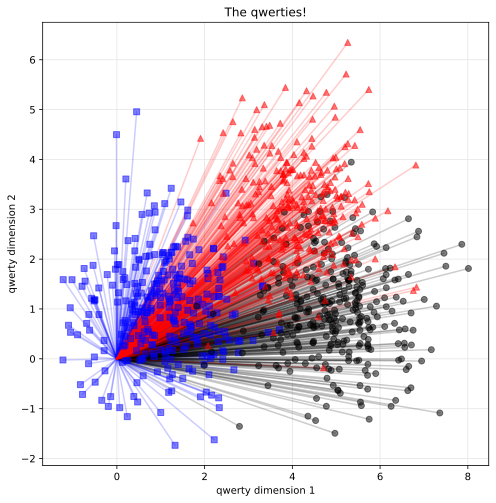

In [ ]:
# create data

nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 3]

# generate data
a = [A[0] + np.random.randn(nPerClust) * blur, A[1] + np.random.randn(nPerClust) * blur]
b = [B[0] + np.random.randn(nPerClust) * blur, B[1] + np.random.randn(nPerClust) * blur]
c = [C[0] + np.random.randn(nPerClust) * blur, C[1] + np.random.randn(nPerClust) * blur]

# true labels
labels_np = np.hstack(
    (np.zeros((nPerClust)), np.ones((nPerClust)), 1 + np.ones((nPerClust)))
)

# concatanate into a matrix
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()  # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(8, 8))
# draw distance to origin
color = "bkr"
print(f"Length of data: {len(data)}")
print(data)
for i in range(len(data)):
    plt.plot(
        [0, data[i][0].cpu()],
        [0, data[i, 1].cpu()],
        color=color[labels[i].cpu()],
        alpha=0.2,
    )

plt.plot(
    data[np.where(labels.cpu() == 0)[0], 0].cpu(),
    data[np.where(labels.cpu() == 0)[0], 1].cpu(),
    "bs",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 1)[0], 0].cpu(),
    data[np.where(labels.cpu() == 1)[0], 1].cpu(),
    "ko",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 2)[0], 0].cpu(),
    data[np.where(labels.cpu() == 2)[0], 1].cpu(),
    "r^",
    alpha=0.5,
)

plt.grid(color=[0.9, 0.9, 0.9])
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

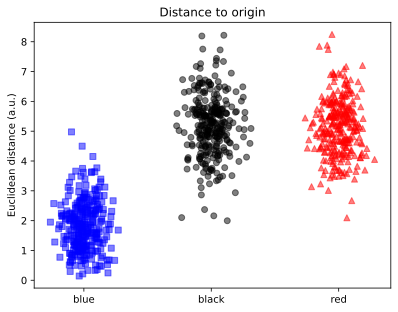

In [58]:
# compute Euclidean distance to the origin
dist2orig = torch.sqrt(data[:, 0] ** 2 + data[:, 1] ** 2)
plt.plot(labels[labels == 0].cpu() + (torch.randn(300) / 10).cpu(), dist2orig[labels == 0].cpu(), "bs", alpha=0.5)
plt.plot(labels[labels == 1].cpu() + (torch.randn(300) / 10).cpu(), dist2orig[labels == 1].cpu(), "ko", alpha=0.5)
plt.plot(labels[labels == 2].cpu() + (torch.randn(300) / 10).cpu(), dist2orig[labels == 2].cpu(), "r^", alpha=0.5)
plt.xticks([0, 1, 2], labels=["blue", "black", "red"], )
plt.ylabel("Euclidean distance (a.u.)")
plt.title("Distance to origin")
plt.show()

In [15]:
# And add that to the data matrix
dataAug = torch.cat((data, dist2orig.view(len(data), 1)), axis=1)

# check data sizes
print(data.shape)
print(dataAug.shape)
print(" ")

# look at some of the data
print(dataAug)

torch.Size([900, 2])
torch.Size([900, 3])
 
tensor([[0.0118, 1.8866, 1.8867],
        [0.9256, 1.5646, 1.8178],
        [0.9931, 1.2284, 1.5796],
        ...,
        [4.5300, 3.9402, 6.0039],
        [3.8387, 1.7253, 4.2086],
        [4.1143, 3.6691, 5.5127]], device='cuda:0')


In [19]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataAug, labels, test_size=0.1
)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True, generator=torch.Generator(device)
)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], generator=torch.Generator(device))

In [21]:
# create a class for the model
def createTheQwertyNet(useExtraFeature=False):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            if useExtraFeature:
                self.input = nn.Linear(3, 8)
            else:
                self.input = nn.Linear(2, 8)

            ### hidden layer
            self.fc1 = nn.Linear(8, 8)

            ### output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):

            # by request, only use XY features
            # print(x.shape) # comment out during training!
            if not useExtraFeature:
                x = x[:, :2]
            # print(x.shape) # comment out during training!

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [22]:
# test the model

print("Using augmented feature:")
net = createTheQwertyNet(True)[0]
net(next(iter(train_loader))[0])

print("\nNot using augmented feature:")
net = createTheQwertyNet(False)[0]
net(next(iter(train_loader))[0])

Using augmented feature:

Not using augmented feature:


tensor([[-0.0498, -0.0933, -0.0534],
        [-0.0965, -0.0490, -0.0444],
        [-0.1040, -0.0279, -0.0185],
        [-0.0112, -0.1673, -0.1220],
        [-0.0657, -0.1175, -0.0909],
        [ 0.0267, -0.2875, -0.1479],
        [ 0.0063, -0.2448, -0.1358],
        [-0.0100, -0.1895, -0.1284],
        [-0.1019, -0.0303, -0.0209],
        [-0.0699, -0.1173, -0.0875],
        [ 0.0016, -0.2006, -0.2108],
        [-0.0175, -0.2237, -0.1188],
        [-0.1099, -0.0212, -0.0118],
        [-0.0403, -0.1485, -0.1082],
        [-0.0746, -0.0667, -0.0242],
        [-0.0627, -0.0799, -0.0405]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [32]:
def trainTheModel(useExtraFeature=False):

    # number of epochs
    numepochs = 200

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet(useExtraFeature)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            net.train() # Training mode
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.cpu().item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y  # booleans (false/true)
            matchesNumeric = matches.float()  # convert to numbers (0/1)
            accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100
            batchAcc.append(accuracyPct.cpu())  # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval() # Evaluation mode
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        with torch.no_grad():  # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append((100 * torch.mean((torch.argmax(yHat, axis=1) == y).float())).cpu())
    # end epochs

    # function output
    return trainAcc, testAcc, losses, net

In [74]:
# Function to plot the results
def plotTheResults():

    # compute accuracy over entire dataset (train+test)
    yHat = net(dataAug)
    predictions = torch.argmax(yHat, axis=1)
    accuracy = (predictions == labels).float()

    # and accuracy by group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100 * torch.mean(accuracy[labels == i])

    # create the figure
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    # plot the loss function
    ax[0, 0].plot(losses.cpu().detach())
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].set_xlabel("epoch")
    ax[0, 0].set_title("Losses")

    # plot the accuracy functions
    ax[0, 1].plot(trainAcc, label="Train")
    ax[0, 1].plot(testAcc, label="Test")
    ax[0, 1].set_ylabel("Accuracy (%)")
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_title("Accuracy")
    ax[0, 1].legend()

    # plot overall accuracy by group
    print('Accuracy Group size: ', accuracyByGroup)
    ax[1, 0].bar(range(3), accuracyByGroup, color=["b", "k", "r"])
    ax[1, 0].set_ylim([np.min(accuracyByGroup) - 5, np.max(accuracyByGroup) + 5])
    ax[1, 0].set_xticks([0, 1, 2])
    ax[1, 0].set_xlabel("Group")
    ax[1, 0].set_ylabel("Accuracy (%)")
    ax[1, 0].set_title("Accuracy by group")

    # scatterplot of correct and incorrect labeled data
    colorShapes = ["bs", "ko", "g^"]  # data markers
    for i in range(3):
        # plot all data points
        ax[1, 1].plot(
            dataAug[labels.cpu() == i, 0].cpu(),
            dataAug[labels.cpu() == i, 1].cpu(),
            colorShapes[i],
            alpha=0.3,
            label=f"Group {i}",
        )

        # cross-out the incorrect ones
        idxErr = (accuracy == 0) & (labels == i)
        ax[1, 1].plot(dataAug[idxErr, 0].cpu(), dataAug[idxErr, 1].cpu(), "rx")

    ax[1, 1].set_title("All groups")
    ax[1, 1].set_xlabel("qwerty dimension 1")
    ax[1, 1].set_ylabel("qwerty dimension 2")
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()

Final accuracy: 92.22%
Accuracy Group size:  [90.         87.         85.33333588]


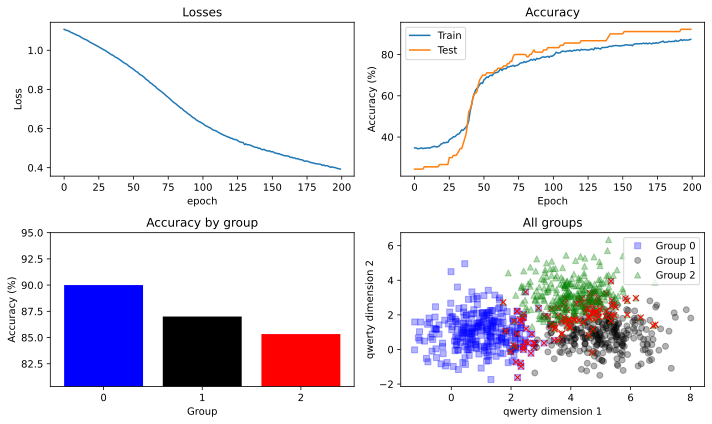

In [75]:
# run the model and visualize the results
trainAcc, testAcc, losses, net = trainTheModel(False)
print("Final accuracy: %.2f%%" % testAcc[-1].item())
plotTheResults()

Final accuracy: 87.78%
Accuracy Group size:  [80.66666412 87.33333588 87.        ]


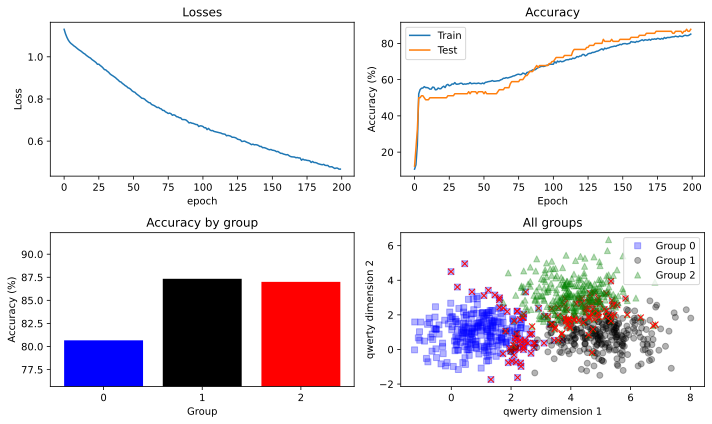

In [76]:
# run the model and visualize the results
trainAcc, testAcc, losses, net = trainTheModel(True)
print("Final accuracy: %.2f%%" % testAcc[-1].item())
plotTheResults()

In [41]:
# Run the experiment multiple times and do a t-test!
# (takes ~3 mins)

finalacc2 = np.zeros(10)
finalacc3 = np.zeros(10)

for i in range(10):
    finalacc2[i] = trainTheModel(False)[1][-1]
    finalacc3[i] = trainTheModel(True)[1][-1]

# show the numbers
print(np.round(np.vstack((finalacc2, finalacc3)).T, 2))

# run the t-test and print the results
from scipy import stats

t, p = stats.ttest_ind(finalacc3, finalacc2)
print("\n\nt=%.2f, p=%.2f" % (t, p))

[[82.22 85.56]
 [93.33 88.89]
 [90.   71.11]
 [91.11 91.11]
 [90.   91.11]
 [87.78 92.22]
 [87.78 92.22]
 [90.   58.89]
 [92.22 86.67]
 [90.   95.56]]


t=-1.10, p=0.29
